# Model 6: Transfer learning model with denoised images and augmentation (validation split)

This model utilizes transfer learning and the functional Keras API to produce a mixed convolutional model on denoised images. Because of imbalance, the melanoma images are augmented, and a validation set was segmented from the augmented data. A dropout layer was included to prevent overfitting. The model utilizes the [Xception](https://keras.io/api/applications/xception/) architecture, trained on the famous [ImageNet](https://image-net.org/) image database.

In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import time

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
meta = pd.read_csv('../processed_data/train.csv', index_col=0)
meta.head()

,age_approx,Unknown,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,target
0,45.0,0,0,1,1,0,0,0,0,0,0
1,45.0,0,1,0,0,0,0,0,0,1,0
2,50.0,0,1,0,0,1,0,0,0,0,0
3,45.0,0,1,0,1,0,0,0,0,0,0
4,55.0,0,1,0,0,0,0,0,0,1,0


### Metadata

In [3]:
y = meta['target'].values.reshape(-1,1)
X = meta.drop('target', axis=1).astype('ushort')

In [4]:
meta.shape

(33126, 11)

In [5]:
y.shape

(33126, 1)

### Image data

In [6]:
PATH = '../processed_data/processed_train_img_array.pkl'
with open(PATH, 'rb') as file:
    img_array = pickle.load(file)
img_array = img_array.astype('ushort')

In [7]:
img_array.shape

(33126, 80, 120, 3)

### Augmentation

In [8]:
# Prepare augmentation files
augmentation_files = pd.read_csv('../data/train.csv', usecols=['image_name'])
augmentation_files = pd.concat([augmentation_files,meta], axis=1)
augmentation_files = augmentation_files[augmentation_files['target'] == 1]
augmentation_files['index'] = range(len(augmentation_files))

raw_files_path = '../data/jpeg/train/'
augmentation_files['image_name'] = augmentation_files['image_name'].map(lambda x: raw_files_path+x+'.jpg')

In [9]:
# Instantiate data generator
aug = ImageDataGenerator(rotation_range=270,
                        height_shift_range=0.1,
                        width_shift_range=0.1,
                        brightness_range=[0.3,0.9],
                        channel_shift_range=50.0,
                        horizontal_flip=True,
                        vertical_flip=True,
                        shear_range=25.0)

In [10]:
ITERATIONS = img_array.shape[0]//len(augmentation_files)
aug.fit(img_array)
img_generator = aug.flow_from_dataframe(dataframe=augmentation_files,
                                        x_col='image_name',
                                        y_col='index',
                                        class_mode='raw',
                                        shuffle=False,
                                        target_size=img_array.shape[1:3],
                                        seed=867_5309
                                       )

# Augment data additional 
img_y = np.empty((1,1))
iteration = 0
for x_batch in img_generator:
    iteration += 1
    img_array = np.concatenate((img_array, x_batch[0]), axis=0)
    img_y = np.concatenate((img_y, x_batch[1].reshape(-1,1)), axis=0)
    print(f'Batch {iteration} completed.')
    if iteration == ITERATIONS:
        break
img_y = img_y[1:]

Found 584 validated image filenames.
Batch 1 completed.
Batch 2 completed.
Batch 3 completed.
Batch 4 completed.
Batch 5 completed.
Batch 6 completed.
Batch 7 completed.
Batch 8 completed.
Batch 9 completed.
Batch 10 completed.
Batch 11 completed.
Batch 12 completed.
Batch 13 completed.
Batch 14 completed.
Batch 15 completed.
Batch 16 completed.
Batch 17 completed.
Batch 18 completed.
Batch 19 completed.
Batch 20 completed.
Batch 21 completed.
Batch 22 completed.
Batch 23 completed.
Batch 24 completed.
Batch 25 completed.
Batch 26 completed.
Batch 27 completed.
Batch 28 completed.
Batch 29 completed.
Batch 30 completed.
Batch 31 completed.
Batch 32 completed.
Batch 33 completed.
Batch 34 completed.
Batch 35 completed.
Batch 36 completed.
Batch 37 completed.
Batch 38 completed.
Batch 39 completed.
Batch 40 completed.
Batch 41 completed.
Batch 42 completed.
Batch 43 completed.
Batch 44 completed.
Batch 45 completed.
Batch 46 completed.
Batch 47 completed.
Batch 48 completed.
Batch 49 com

In [11]:
# Join metadata
new_metadata = pd.DataFrame(img_y, columns=['index']).astype('int')
new_metadata = pd.merge(new_metadata,augmentation_files,
                        on='index',
                        how='left',
                        validate='many_to_many')[meta.columns]

meta = pd.concat([meta, new_metadata.drop('target', axis=1)])
y = np.concatenate([y, new_metadata['target'].values.reshape(-1,1)])

### Model

In [12]:
LEARNING_RATE = 0.001
recall = Recall(name='recall')

# Define inputs
meta_inputs = Input(shape=(10,))
img_inputs = Input(shape=(80,120,3,))

# Model 1
meta_model = Dense(4, activation='relu')(meta_inputs)
meta_model = Dense(4, activation='relu')(meta_model)

# Model 2
img_model = Xception(include_top=False, input_shape=(80,120,3,))(img_inputs)
img_model = Conv2D(8, kernel_size=(5,5),
                         padding='same',
                         activation='relu')(img_model)
img_model = GlobalAveragePooling2D()(img_model)
img_model = Dropout(rate=0.35)(img_model)

# Merge models
merged_model = Concatenate()([meta_model, img_model])
merged_model = Dense(4, activation='relu',
                     kernel_regularizer=l2(l=0.04))(merged_model)
merged_output = Dense(1, activation='sigmoid')(merged_model)


# Define functional model
model = Model(inputs=[meta_inputs, img_inputs], outputs=merged_output)

# Compile model
auc = AUC(name = 'auc')
model.compile(Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=[auc, recall])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 120, 3)] 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 4, 2048)   20861480    input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 3, 4, 8)      409608      xception[0][0]                   
______________________________________________________________________________________________

See `fchollet`'s discussion of class weights [here](https://keras.io/examples/structured_data/imbalanced_classification/).

In [13]:
weight_for_0 = 1.0 / ((len(y)-y.sum())/len(y))
weight_for_1 = 1.0 / (y.sum()/len(y))
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.0715383197099133, 1: 14.978522336769759}

In [14]:
EPOCHS = 10
BATCH_SIZE = 5

In [15]:
history = model.fit(x=[X, img_array], y=y,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    batch_size=BATCH_SIZE,
                    validation_split=0.3)

Epoch 1/10
4638/4638 [==============================] - 234s 48ms/step - loss: 1.5749 - auc: 0.4648 - recall: 0.0000e+00 - val_loss: 0.3074 - val_auc: 0.3913 - val_recall: 0.0109
Epoch 2/10
4638/4638 [==============================] - 223s 48ms/step - loss: 0.7528 - auc: 0.5160 - recall: 0.0000e+00 - val_loss: 1.4420 - val_auc: 0.6197 - val_recall: 0.0000e+00
Epoch 3/10
4638/4638 [==============================] - 221s 48ms/step - loss: 0.6704 - auc: 0.5834 - recall: 0.0000e+00 - val_loss: 0.4990 - val_auc: 0.7160 - val_recall: 0.0000e+00
Epoch 4/10
4638/4638 [==============================] - 221s 48ms/step - loss: 0.6483 - auc: 0.6552 - recall: 0.0000e+00 - val_loss: 0.2864 - val_auc: 0.7554 - val_recall: 0.0000e+00
Epoch 5/10
4638/4638 [==============================] - 221s 48ms/step - loss: 0.6556 - auc: 0.6510 - recall: 0.0000e+00 - val_loss: 0.1330 - val_auc: 0.7607 - val_recall: 0.0000e+00
Epoch 6/10
4638/4638 [==============================] - 221s 48ms/step - loss: 0.6413 - a

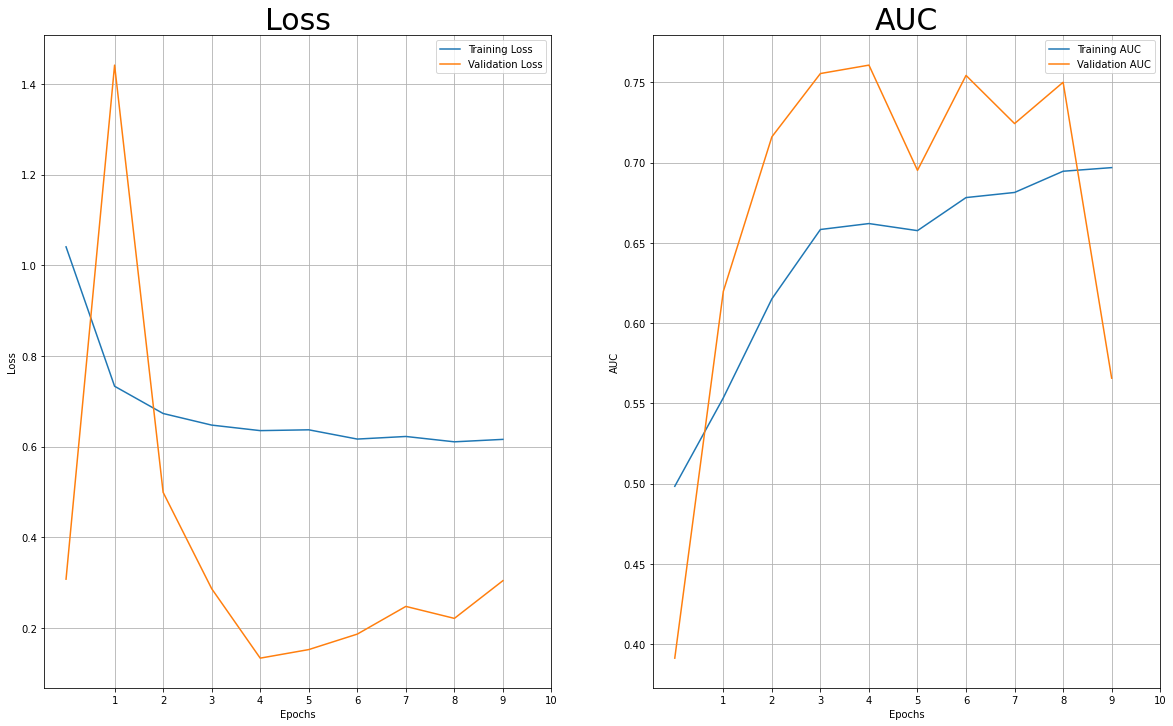

In [16]:
X_length = np.arange(0, EPOCHS)

plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(X_length, history.history['loss'], label = 'Training Loss')
plt.plot(X_length, history.history['val_loss'], label = 'Validation Loss')
plt.grid(True)
plt.xticks(X_length+1)
plt.legend()
plt.title('Loss', fontsize=30)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.plot(X_length, history.history['auc'], label = 'Training AUC')
plt.plot(X_length, history.history['val_auc'], label = 'Validation AUC')
plt.grid(True)
plt.xticks(X_length+1)
plt.legend()
_ = plt.title('AUC', fontsize=30)